# EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


 BASIC INFO
Shape: (104, 5)

Data types:
 id              int64
job_title      object
location       object
connection      int64
fit           float64
dtype: object

Missing values per column:
 id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64

First 5 rows:
    id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                              location  connection  fit  
0                       Houston, Texas          85  NaN  
1                               Kanada         500  NaN  
2  Raleigh-Durham, North Carolina Area          44  NaN  
3                        Denton, Texas         500  NaN  
4                       İzmir, Tür

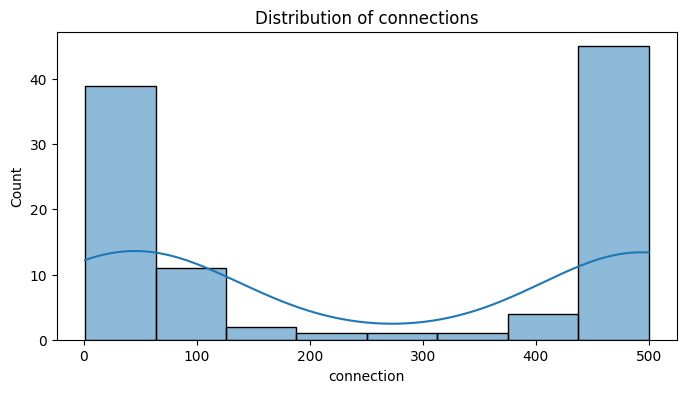


Outlier count for connections (|z|>3):
0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore

#Load data
df = pd.read_csv("/content/potential-talents.csv")

df['connection'] = df['connection'].astype(str)
df['connection'] = df['connection'].str.strip()

#Replace '500+' with '500' and convert entire column to int
df['connection'] = df['connection'].replace('500+', '500').astype(int)

#Basic info
print("\n BASIC INFO")
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nFirst 5 rows:\n", df.head())

#Summary statistics
print("\n--- SUMMARY STATISTICS ---")
print(df.describe(include='all'))  #includes categorical features

#Cat vs Num split
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

#Categorical value count
for col in categorical_cols:
    print(f"\nColumn '{col}' unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(10))

#Numerical feature distribution
plt.figure(figsize=(8,4))
sns.histplot(df['connection'].dropna(), kde=True)
plt.title(f"Distribution of connections")
plt.show()

#Outlier detection with Z-score
z_scores = np.abs(zscore(df['connection'].dropna()))
outliers = (z_scores > 3).sum(axis=0)
print("\nOutlier count for connections (|z|>3):")
print(outliers)


#Main Implementation (LGBMRanker, MiniLM, BERT, MPNet)

In [ ]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
from lightgbm import LGBMRanker, LGBMClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#Parameters
JOB_DESCRIPTION = "seeking human resources"
STARRED_IDS = [1, 3, 6, 7, 9, 10, 13, 14, 15, 17, 19, 21, 24, 25, 27, 28, 29, 30, 31, 44] #Star similar profiles, and upto 15 for better results
TEXT_COL = "job_title"
CONN_COL = "connection"
ID_COL = "id"
TOP_K = 20
USE_SENTENCE_TRANSFORMER = True

In [ ]:
#Utility functions (clean and normalize connections)
def clean_connection_value(x) -> int:
    if pd.isna(x):
        return 0
    if isinstance(x, (int, float)) and not isinstance(x, bool):
        try:
            return int(x)
        except Exception:
            return 0
    s = str(x).strip()
    m = re.match(r"^\s*(\d+)\s*\+?\s*$", s)
    if m:
        return int(m.group(1))
    m = re.search(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return 0

def normalize_connections_array(arr: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr, dtype=float).reshape(-1, 1)
    scaler = StandardScaler(with_mean=True, with_std=True)
    try:
        norm = scaler.fit_transform(arr).reshape(-1)
        norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        norm = np.zeros(arr.shape[0], dtype=float)
    return norm

In [ ]:
#Load and preprocess data
df = pd.read_csv("/content/potential-talents.csv")

#Convert connections to int
df[CONN_COL] = df[CONN_COL].apply(clean_connection_value).astype(int)

#Create text field from job_title (candidate text) we only use job_title per user request
df["_text"] = df[TEXT_COL].fillna("").astype(str).str.strip()

#Build job description text
job_text = str(JOB_DESCRIPTION).strip()
if job_text == "":
    raise ValueError("JOB_DESCRIPTION is empty. Provide a brief job description or keywords.")

#Create model objects
model_minilm = SentenceTransformer("all-MiniLM-L6-v2")
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
model_dbert = SentenceTransformer("sentence-transformers/multi-qa-distilbert-cos-v1")

#Encode features with MiniLM
candidate_embs_minilm = model_minilm.encode(df["_text"].tolist(), convert_to_numpy=True, show_progress_bar=False)
job_emb_minilm = model_minilm.encode([job_text], convert_to_numpy=True, show_progress_bar=False)[0].reshape(1, -1)

#Encode features with MPNet
candidate_embs_mpnet = model_mpnet.encode(df["_text"].tolist(), convert_to_numpy=True, show_progress_bar=False)
job_emb_mpnet = model_mpnet.encode([job_text], convert_to_numpy=True, show_progress_bar=False)[0].reshape(1, -1)

#Encode features with DistilBERT
candidate_embs_dbert = model_dbert.encode(df["_text"].tolist(), convert_to_numpy=True, show_progress_bar=False)
job_emb_dbert = model_dbert.encode([job_text], convert_to_numpy=True, show_progress_bar=False)[0].reshape(1, -1)

#Compute cosine similarity per model
sim_minilm = cosine_similarity(candidate_embs_minilm, job_emb_minilm.reshape(1, -1)).reshape(-1)
sim_mpnet  = cosine_similarity(candidate_embs_mpnet,  job_emb_mpnet.reshape(1, -1)).reshape(-1)
sim_distil = cosine_similarity(candidate_embs_dbert, job_emb_dbert.reshape(1, -1)).reshape(-1)

#Add them into dataframe for inspection
df["sim_minilm"] = sim_minilm
df["sim_mpnet"]  = sim_mpnet
df["sim_distil"] = sim_distil

#Build feature matrix
conn_norm = normalize_connections_array(df[CONN_COL].to_numpy())

#Assemble final features
X = np.vstack([sim_distil, sim_minilm, sim_mpnet, conn_norm]).T

feature_names = ["sim_distil", "sim_minilm", "sim_mpnet", "conn_norm"]

#Create target based on STARRED_IDS (0/1)
starred_set = set(int(x) for x in STARRED_IDS)
y = np.array([1 if int(r) in starred_set else 0 for r in df[ID_COL].tolist()])

In [ ]:
#Baseline cosine similarity scores
sim_scores = cosine_similarity(candidate_embs_minilm, job_emb_minilm).reshape(-1)

#Min-Max normalised
sim_scores = (sim_scores - sim_scores.min()) / (sim_scores.max() - sim_scores.min() + 1e-12)

#Train LightGBM Ranker
def train_and_score_lgbm_ranker(X, y, df, feature_names, group=None, random_state=42):

    #Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

    #If all labels identical, ranker can't learn
    if np.unique(y_train).size <= 1:
        print("All labels identical (no starred or all starred). Cannot train ranker reliably.")
        return None

    #LGBMRanker expects groups, ie. list of group sizes. For a single job, group = [n_samples].
    group_train = [X_train.shape[0]]
    group_test = [X_test.shape[0]]

    try:
        ranker = LGBMRanker(
            objective="lambdarank",
            metric="ndcg",
            n_estimators=200,
            random_state=random_state,
            importance_type='gain'
        )
        ranker.fit(X_train, y_train, group=group_train, eval_set=[(X_test, y_test)], eval_group=[group_test], eval_at=[5, 10])
        preds = ranker.predict(X)
        return preds, ranker
    except Exception as e:
        print("LGBMRanker training failed:", e)
        return None

In [ ]:
#Train ranker
result = train_and_score_lgbm_ranker(X, y, df, feature_names)

#Retrieve predictions from output
preds, ranker_model = result
model_used = "lgbm_ranker"
print("Trained LGBMRanker successfully.")

#Normalize predictions to 0-1 for readability
preds = np.asarray(preds, dtype=float)
preds = (preds - preds.min()) / (preds.max() - preds.min() + 1e-12)

#Add results to DataFrame and show top-K
df_result = df.copy()
df_result["fit_score_model"] = preds
df_result["fit_score_similarity"] = sim_scores
df_result["starred_label"] = y
df_result["sim_minilm"] = sim_minilm
df_result["sim_mpnet"]  = sim_mpnet
df_result["sim_distil"] = sim_distil

#Show top candidates by similarity baseline for reference
topk_sim = df_result.sort_values("fit_score_similarity", ascending=False).head(TOP_K)
print(f"\nTop {TOP_K} candidates by similarity baseline:")
display(topk_sim[[ID_COL, TEXT_COL, CONN_COL, "starred_label", "fit_score_similarity"]])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


,id,job_title,connection,starred_label,fit_score_similarity
98,99,Seeking Human Resources Position,48,0,1.000000
27,28,Seeking Human Resources Opportunities,390,1,0.993776
29,30,Seeking Human Resources Opportunities,390,1,0.993776
39,40,Seeking Human Resources HRIS and Generalist Po...,500,0,0.879198
52,53,Seeking Human Resources HRIS and Generalist Po...,500,0,0.879198
61,62,Seeking Human Resources HRIS and Generalist Po...,500,0,0.879198
9,10,Seeking Human Resources HRIS and Generalist Po...,500,1,0.879198
5,6,Aspiring Human Resources Specialist,1,1,0.844875
59,60,Aspiring Human Resources Specialist,1,0,0.844875
35,36,Aspiring Human Resources Specialist,1,0,0.844875


In [ ]:
#Show top candidates by model score
topk_model = df_result.sort_values("fit_score_model", ascending=False).head(TOP_K)
print(f"\nTop {TOP_K} candidates by model ({model_used}):")
display(topk_model[[ID_COL, TEXT_COL, CONN_COL, "starred_label", "fit_score_model", "sim_minilm", "sim_mpnet", "sim_distil"]])


Top 20 candidates by model (lgbm_ranker):


,id,job_title,connection,starred_label,fit_score_model,sim_minilm,sim_mpnet,sim_distil
27,28,Seeking Human Resources Opportunities,390,1,1.000000,0.899172,0.880791,0.895943
29,30,Seeking Human Resources Opportunities,390,1,1.000000,0.899172,0.880791,0.895943
0,1,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
14,15,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
13,14,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
18,19,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
30,31,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
43,44,2019 C.T. Bauer College of Business Graduate (...,85,1,0.838450,0.427339,0.568240,0.335852
56,57,2019 C.T. Bauer College of Business Graduate (...,85,0,0.838450,0.427339,0.568240,0.335852
98,99,Seeking Human Resources Position,48,0,0.834293,0.904125,0.820258,0.808340


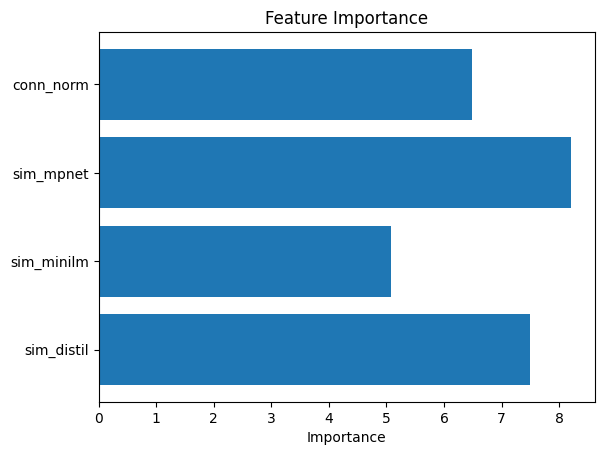

In [ ]:
import matplotlib.pyplot as plt
importances = ranker_model.feature_importances_
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()